In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [113]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.autograd import Variable
from torchsummary import summary

In [115]:
import sys
import cv2

In [114]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from PIL import Image
from base64 import b64decode

In [116]:
from pathlib import Path
import time

In [117]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [118]:
classes_train = Path('/content/gdrive/MyDrive/Colab Notebooks/train')
classes_test = Path('/content/gdrive/MyDrive/Colab Notebooks/test')

In [119]:
train_class = ImageFolder(classes_train)
train_class_name = train_class.classes
train_class_name

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [120]:
test_class = ImageFolder(classes_test)
test_class_name = test_class.classes
test_class_name

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [121]:
train_tfms = tt.Compose([tt.Grayscale(num_output_channels=3),
                         tt.RandomHorizontalFlip(),
                         tt.RandomRotation(30),
                         tt.ToTensor()])

test_tfms = tt.Compose([tt.Grayscale(num_output_channels=3), tt.ToTensor()])

In [122]:
train_ds = ImageFolder(classes_train, train_tfms)
test_ds = ImageFolder(classes_test, test_tfms)

In [123]:
batch_size = 16

In [124]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size, num_workers=3, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [125]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
        break

torch.Size([3, 240, 640])


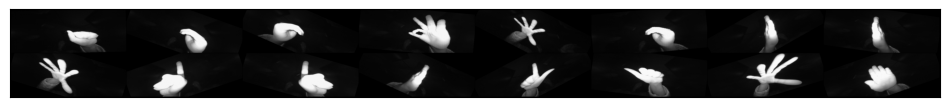

In [126]:
show_batch(train_dl)

In [127]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [128]:
device = get_default_device()
device

device(type='cuda')

In [129]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

**Common model**

In [130]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
              nn.BatchNorm2d(out_channels),
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

# Значительно урезали архитектуру сети, чтобы не было ошибки
# переполнения памяти
class resnet_lite(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.conv1 = conv_block(in_channels, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)

        self.classifier = nn.Sequential(nn.MaxPool2d(6),
                                        nn.Flatten(),
                                        nn.Linear(135680, num_classes))

    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)

        out = self.classifier(out)
        return out

In [131]:
model = to_device(resnet_lite(3, 10), device)

In [132]:
torch.cuda.empty_cache()
epochs = 7
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), max_lr, weight_decay=weight_decay)

In [133]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

7 epochs, 125 total_steps per epoch


In [ ]:
epoch_losses = []

for epoch in range(epochs):

    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()

        optimizer.zero_grad()

        outputs = model(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  190.68722359848022
Epoch 2, loss:  5.0029664960339435
Epoch 3, loss:  2.2285049108521857
Epoch 4, loss:  1.6783971873985775
Epoch 5, loss:  1.9089945091654215
Epoch 6, loss:  1.281555639312232
Epoch 7, loss:  1.0998236731243671


Text(0.5, 1.0, 'losses vs. No. of epochs')

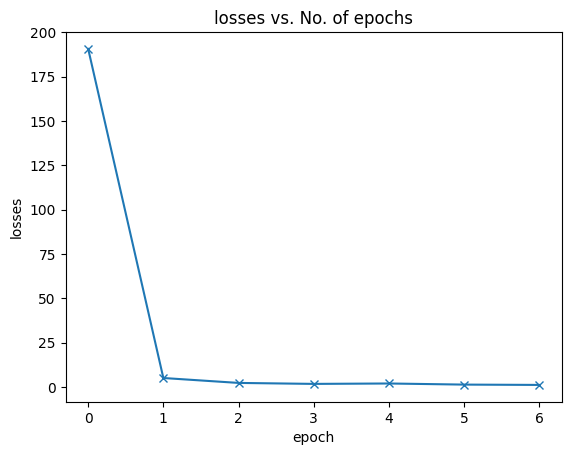

In [ ]:
losses = [np.mean(loss) for loss in epoch_losses]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.title('losses vs. No. of epochs')

In [24]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/my_mod.pth')

In [33]:
resnet_lite = model.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/my_mod.pth'))

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


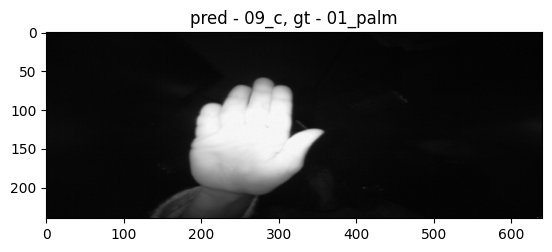

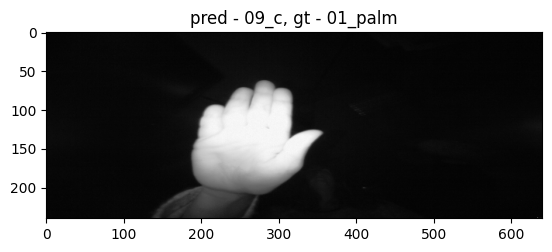

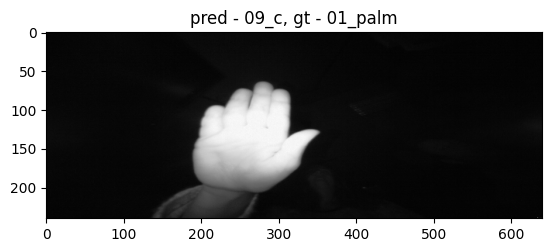

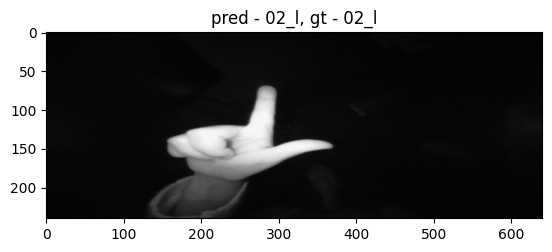

In [47]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        plt.title(f'pred - {test_class_name[outputs[0].argmax()]}, gt - {test_class_name[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>5:
            break

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)

  return filename

In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))

  display(Image(filename))
except Exception as err:
  print(str(err))

<IPython.core.display.Javascript object>

Saved to photo.jpg
'module' object is not callable


Automatically created module for IPython interactive environment


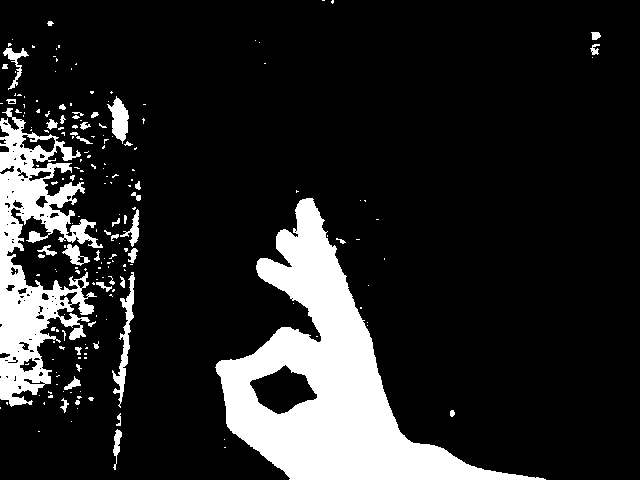

In [ ]:
hsv_min = np.array((2, 28, 65), np.uint8)
hsv_max = np.array((26, 238, 255), np.uint8)

if __name__ == '__main__':
    print(__doc__)

    fn = 'photo.jpg'
    img = cv2.imread(fn)

    imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ret, thresh = cv2.threshold(imgray, 30, 255, cv2.THRESH_BINARY)
    cv2_imshow(thresh)
    cv2.waitKey(0)
    cv2.imwrite('image_4.jpg', thresh)
    !cp image_4.jpg '/content/gdrive/MyDrive/Colab Notebooks/'
    cv2.destroyAllWindows()

In [145]:
gest = {'img': ['image_1.jpg', 'image_2.jpg', 'image_3.jpg', 'image_4.jpg'],
        'path': ['/content/gdrive/MyDrive/Colab Notebooks/image_1.jpg', '/content/gdrive/MyDrive/Colab Notebooks/image_2.jpg', \
                 '/content/gdrive/MyDrive/Colab Notebooks/image_3.jpg', '/content/gdrive/MyDrive/Colab Notebooks/image_4.jpg'],
        'gest': [0, 2, 4, 6]}
df = pd.DataFrame(gest)
df

,img,path,gest
0,image_1.jpg,/content/gdrive/MyDrive/Colab Notebooks/image_...,0
1,image_2.jpg,/content/gdrive/MyDrive/Colab Notebooks/image_...,2
2,image_3.jpg,/content/gdrive/MyDrive/Colab Notebooks/image_...,4
3,image_4.jpg,/content/gdrive/MyDrive/Colab Notebooks/image_...,6


In [146]:
class LeapGests(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing

        self.image_paths = self.data.iloc[:, 1]
        self.image_gest = self.data.iloc[:, 2]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)

        if self.preprocessing is not None:
            img = self.preprocessing(img)

        gest = self.image_gest[idx]

        return img, gest

In [147]:
test_dataset = LeapGests(df, test_tfms)

In [148]:
test_loader = torch.utils.data.DataLoader(test_dataset,
                          batch_size=1,
                          shuffle=False,
                          num_workers=1)

In [149]:
dl = DeviceDataLoader(test_loader, device)

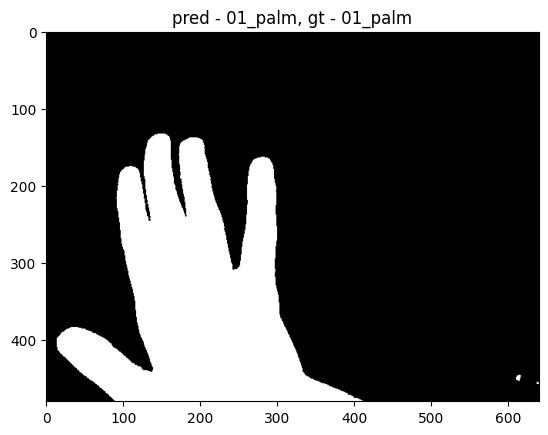

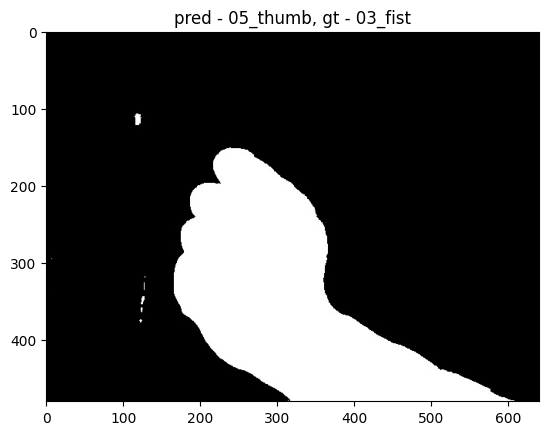

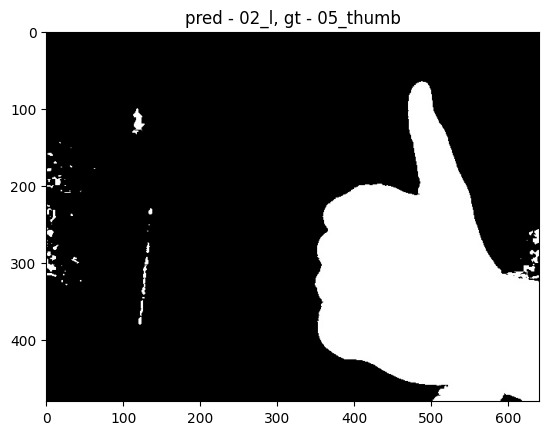

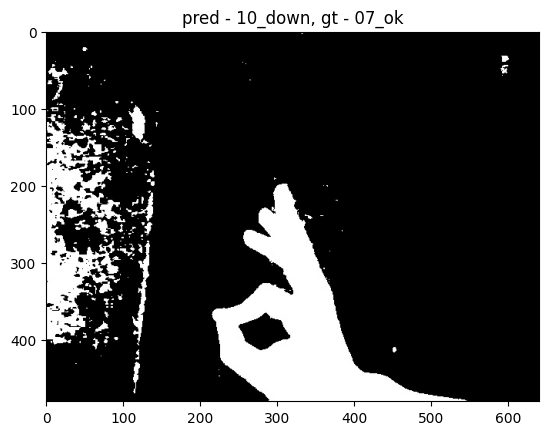

In [53]:
with torch.no_grad():
    for i, data in enumerate(dl):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = model(images)
        plt.title(f'pred - {test_class_name[outputs[0].argmax()]}, gt - {test_class_name[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>3:
            break

*Ввиду того что сеть достаточно проста получили плохое качество*

**model RESNET18**

In [134]:
resnet18 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
summary(resnet18.to(device), input_size=(3, 128, 128))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [135]:
for param in list(resnet18.parameters())[:]:
  param.requires_grad = False

In [136]:
in_features = resnet18.fc.in_features
fc = nn.Linear(in_features=in_features, out_features=10)
resnet18.fc = fc
summary(resnet18.to(device), input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [137]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

criterion = nn.CrossEntropyLoss().to(device)

In [138]:
torch.cuda.empty_cache()
epochs = 20
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), max_lr, weight_decay=weight_decay)

In [139]:
total_steps = len(train_dl)
print(f'{epochs} epochs, {total_steps} total_steps per epoch')

20 epochs, 125 total_steps per epoch


In [140]:
epoch_losses = []

for epoch in range(epochs):

    time1 = time.time()
    running_loss = 0.0
    epoch_loss = []
    for batch_idx, (data, labels) in enumerate(train_dl):
        data, labels = Variable(data), Variable(labels)
        data = data.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        outputs = resnet18(data)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_loss.append(loss.item())
        if (batch_idx+1) % 10000 == 9999:
            print(f'Train Epoch: {epoch+1}, Loss: {running_loss/10000}')
            time2 = time.time()
            print(f'Spend time for 10000 images: {time2 - time1} sec')
            time1 = time.time()
            running_loss = 0.0
    print(f'Epoch {epoch+1}, loss: ', np.mean(epoch_loss))
    epoch_losses.append(epoch_loss)

Epoch 1, loss:  2.001098958015442
Epoch 2, loss:  1.384007152557373
Epoch 3, loss:  1.0037824082374573
Epoch 4, loss:  0.7595497155189515
Epoch 5, loss:  0.6117577757835388
Epoch 6, loss:  0.5126013188362122
Epoch 7, loss:  0.4169590839147568
Epoch 8, loss:  0.37162388503551486
Epoch 9, loss:  0.31613942074775697
Epoch 10, loss:  0.28678988182544707
Epoch 11, loss:  0.25574309599399564
Epoch 12, loss:  0.23886770230531693
Epoch 13, loss:  0.20931174099445343
Epoch 14, loss:  0.19536885565519332
Epoch 15, loss:  0.18186605018377305
Epoch 16, loss:  0.1512047694325447
Epoch 17, loss:  0.15407034027576447
Epoch 18, loss:  0.14394460028409958
Epoch 19, loss:  0.1453954917192459
Epoch 20, loss:  0.13512363958358764


In [141]:
torch.save(resnet18, '/content/gdrive/MyDrive/Colab Notebooks/resnet18_trained.pth')

In [142]:
resnet18= torch.load('/content/gdrive/MyDrive/Colab Notebooks/resnet18_trained.pth')

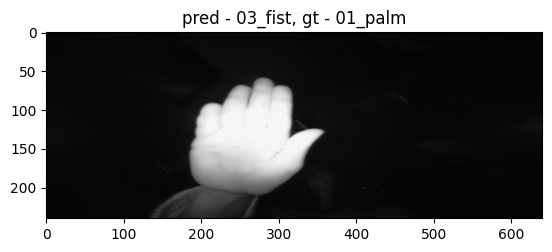

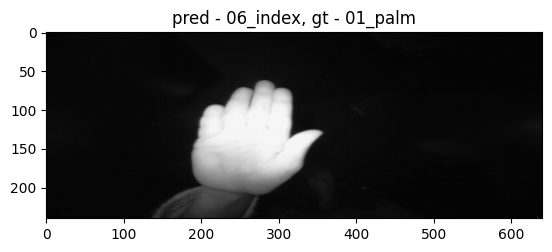

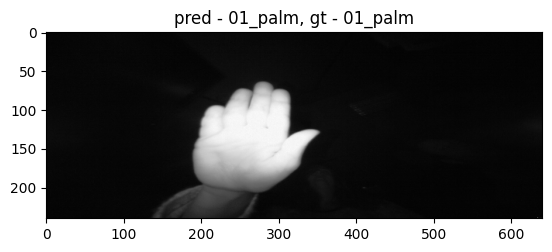

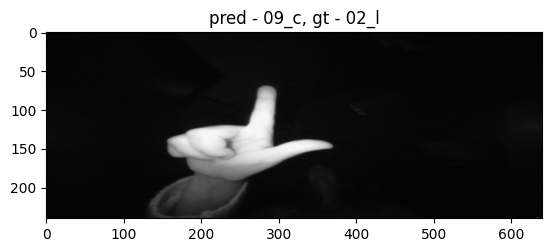

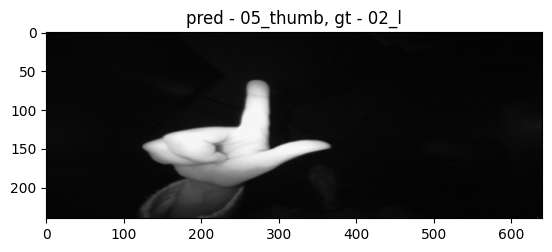

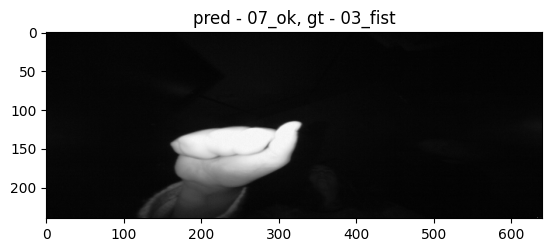

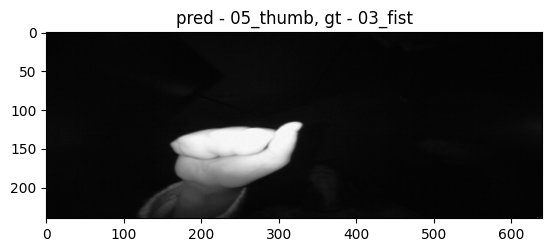

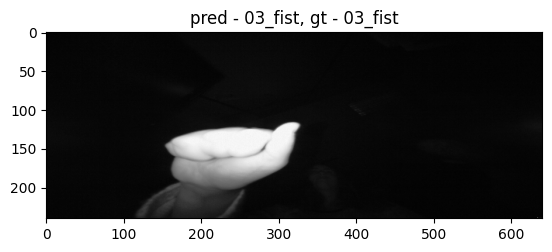

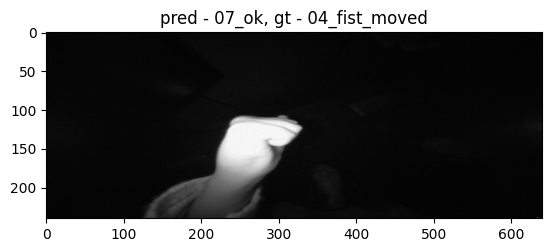

In [143]:
with torch.no_grad():
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet18(images)
        plt.title(f'pred - {test_class_name[outputs[0].argmax()]}, gt - {test_class_name[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>10:
            break

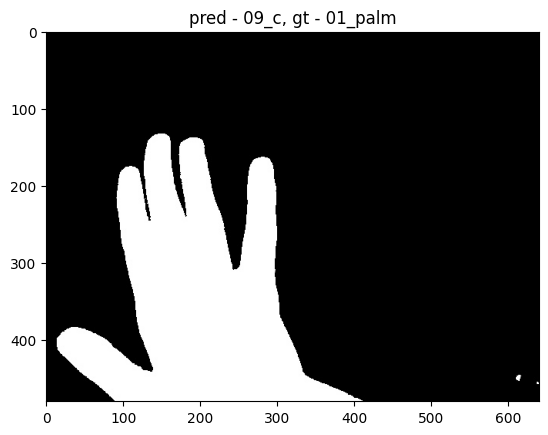

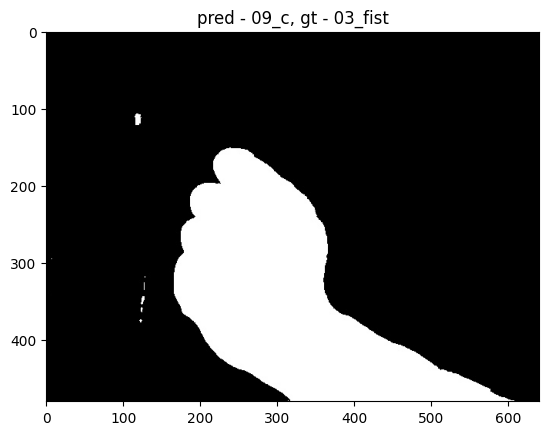

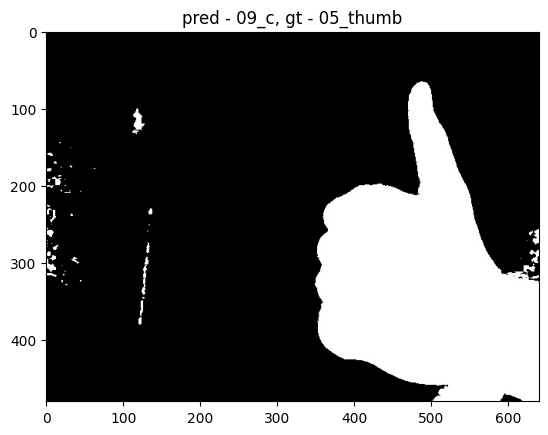

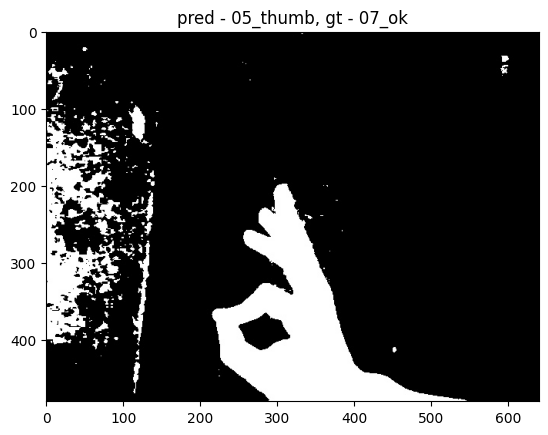

In [150]:
with torch.no_grad():
    for i, data in enumerate(dl):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = resnet18(images)
        plt.title(f'pred - {test_class_name[outputs[0].argmax()]}, gt - {test_class_name[labels[0]]}')
        plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        plt.show()
        if i>3:
            break

*Как видно из предсказаний модель всё ещё не справляется с классификацией.*